<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/Gan_%EC%B2%AB%EA%B1%B8%EC%9D%8C/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [ ]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [ ]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # normalization
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

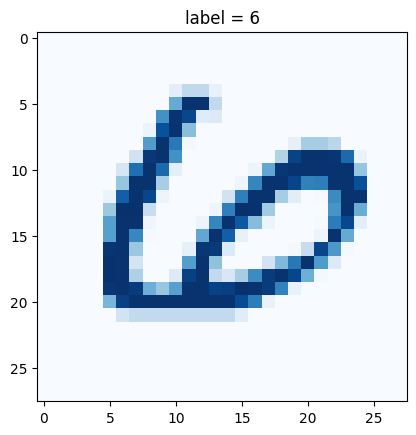

In [ ]:
mnist_dataset = MnistDataset('./sample_data/mnist_train_small.csv')
mnist_dataset.plot_image(0)

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

### 판별기
- 이미지텐서와 레이블텐서를 단순히 결합
  - 레이블 텐서는 One-hot encoding이 되어있음


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784+10, 200), # 레이블 텐서 추가
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, image_tensor, label_tensor):
        # 레이블 텐서 결합
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)

    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


- 판별기를 학습할때 생성데이터를 학습하려면 임의의 이미지와 함께 임의의 클래스 레이블이 필요함
  - 임의의 원핫인코딩 레이블 벡터를 생성하는 함수 제작

In [ ]:
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

In [ ]:
%%time
D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 1min 27s, sys: 211 ms, total: 1min 28s
Wall time: 1min 34s


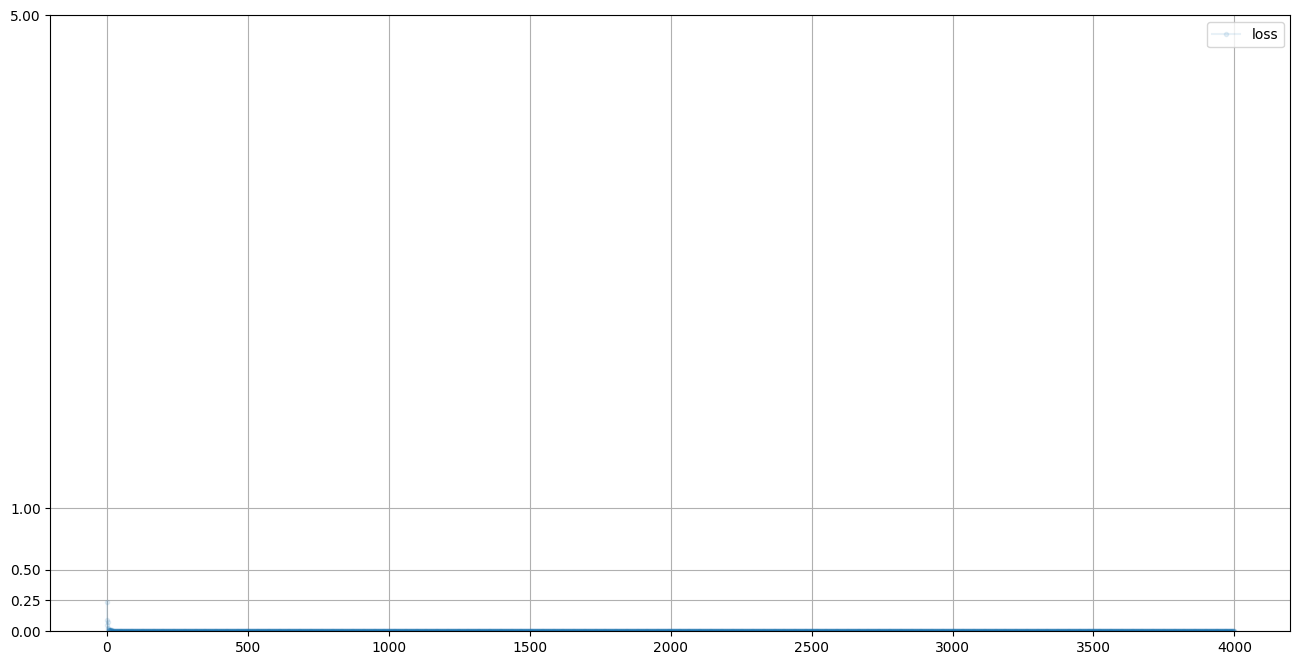

In [ ]:
D.plot_progress()

- 기존 판별기와 별 차이가 없음

### 생성기
- 판별기와 똑같이 텐서레이블을 결합하여 신경망에 전달

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100+10, 200), #
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, seed_tensor, label_tensor):
        inputs = torch.cat((seed_tensor, label_tensor)) # 텐서 결합
        return self.model(inputs)

    def train(self, D, inputs, label_tensor, targets):
        g_outputs = self.forward(inputs, label_tensor)
        d_outputs = D.forward(g_outputs, label_tensor)
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])

        df.plot(ylim=(0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

    # 주어진 조건에 맞는 이미지 생성 함수
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(self.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')


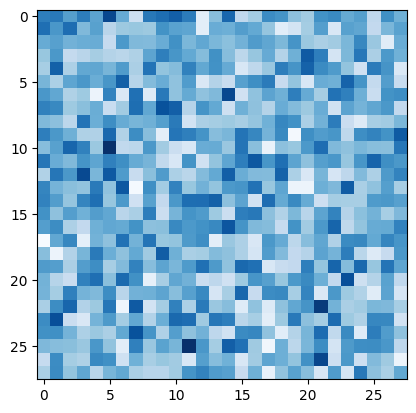

In [ ]:
G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

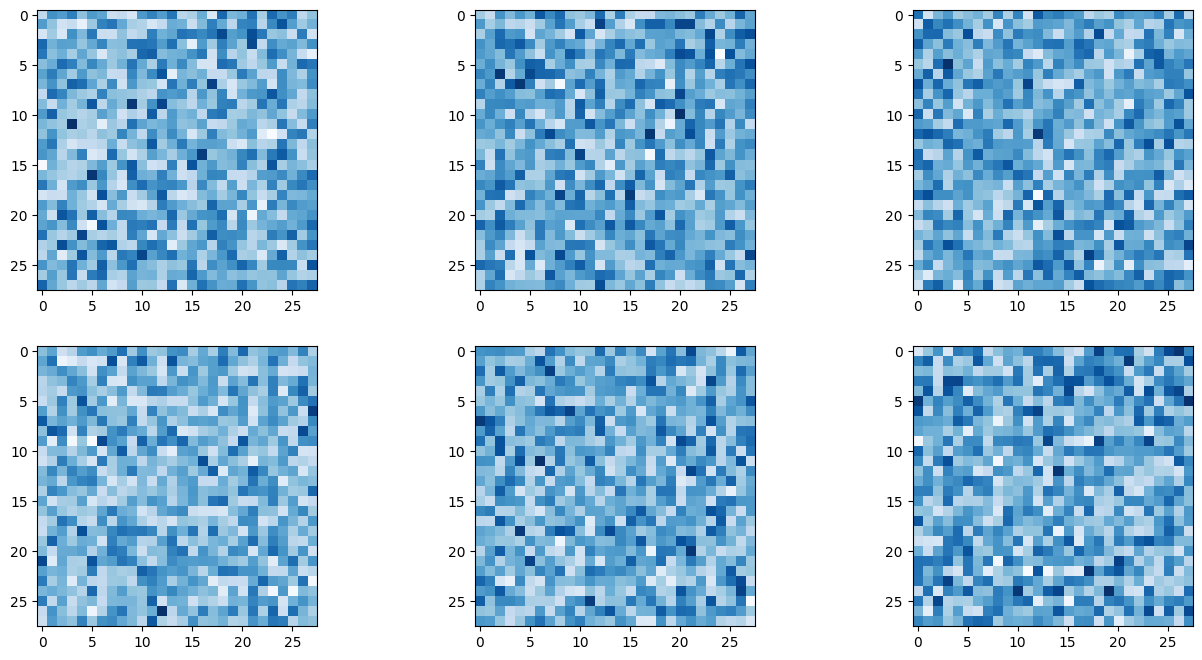

In [ ]:
G.plot_images(1)

### GAN 학습

In [ ]:
D = Discriminator()
G = Generator()

In [ ]:
%%time

# train Discriminator and Generator

epochs = 10

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    random_label = generate_random_one_hot(10)
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), generate_random_one_hot(10), torch.FloatTensor([1.0]))

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
epoch =  2
counter =  50000
counter =  60000
counter =  70000
counter =  80000
epoch =  3
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
epoch =  5
counter =  170000
counter =  180000
counter =  190000
counter =  200000
epoch =  6
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  7
counter =  250000
counter =  260000
counter =  270000
counter =  280000
epoch =  8
counter =  290000
counter =  300000
counter =  310000
counter =  320000
epoch =  9
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  10
counter =  370000
counter =  380000
counter =  390000
counter =  400000
CPU times: user 25min 29s, sys: 2.98 s, total: 25min 32s
Wall time: 25min 59s


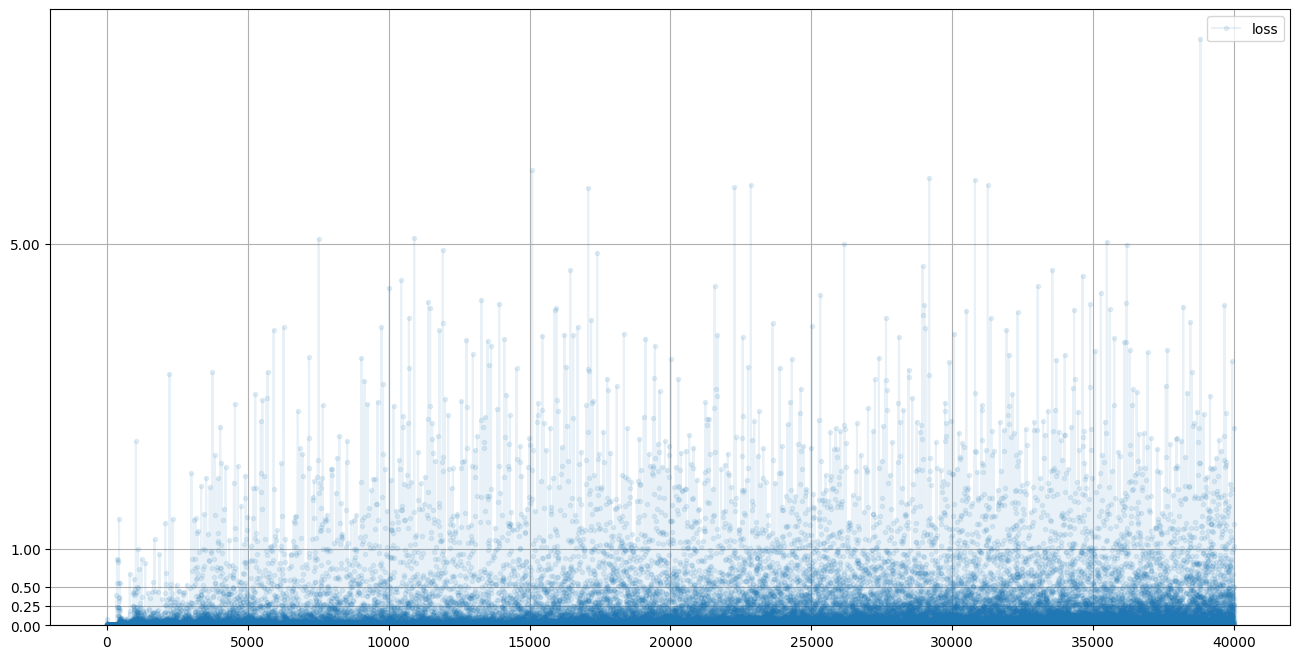

In [ ]:
D.plot_progress()

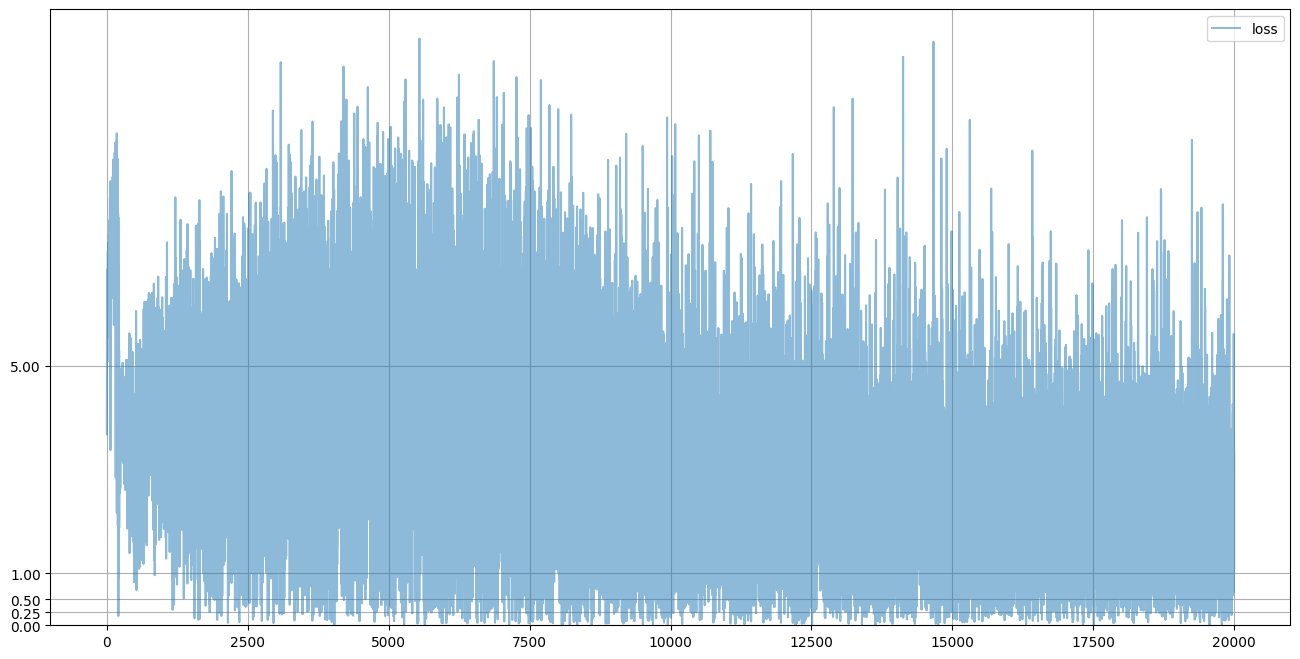

In [ ]:
G.plot_progress()

- 손실값이 0에 가깝지 않음 == 이상적인 현상
- GAN을 훈련할 때 레이블 정보가 도움이 된다.

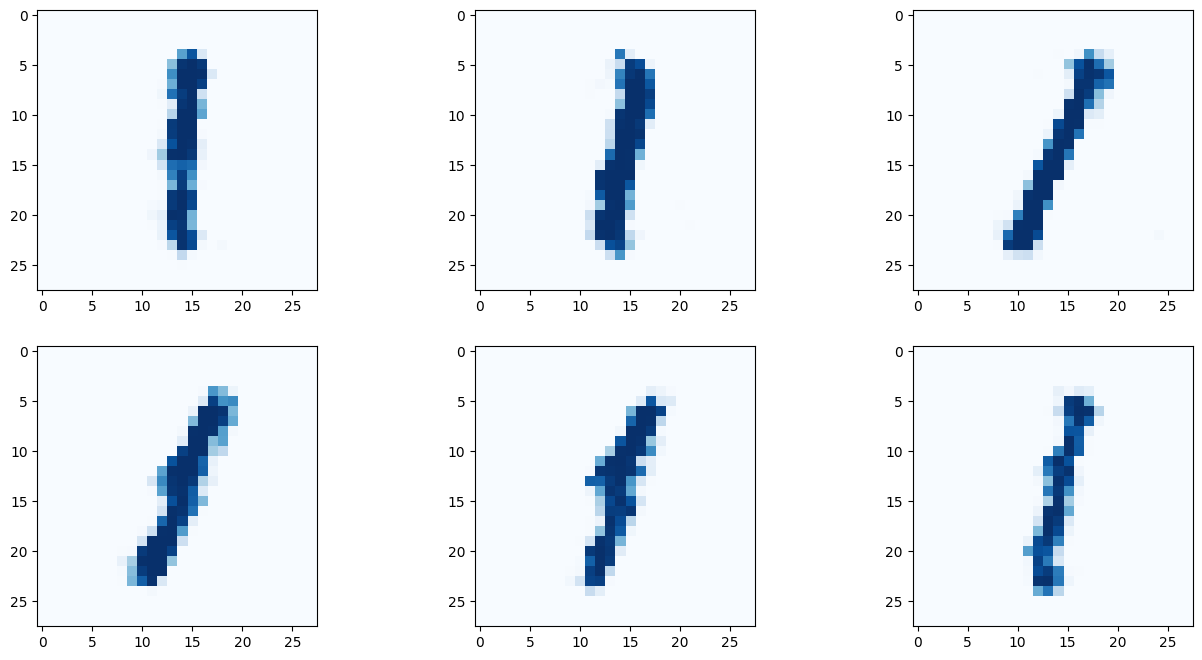

In [ ]:
G.plot_images(1)

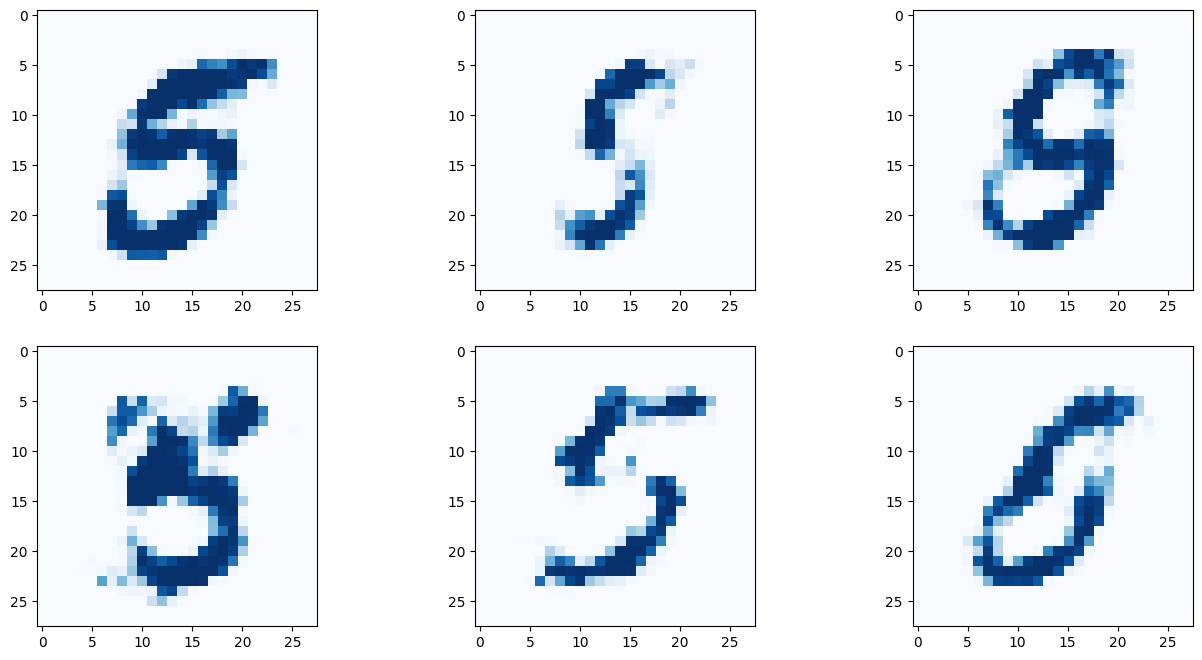

In [ ]:
G.plot_images(5)

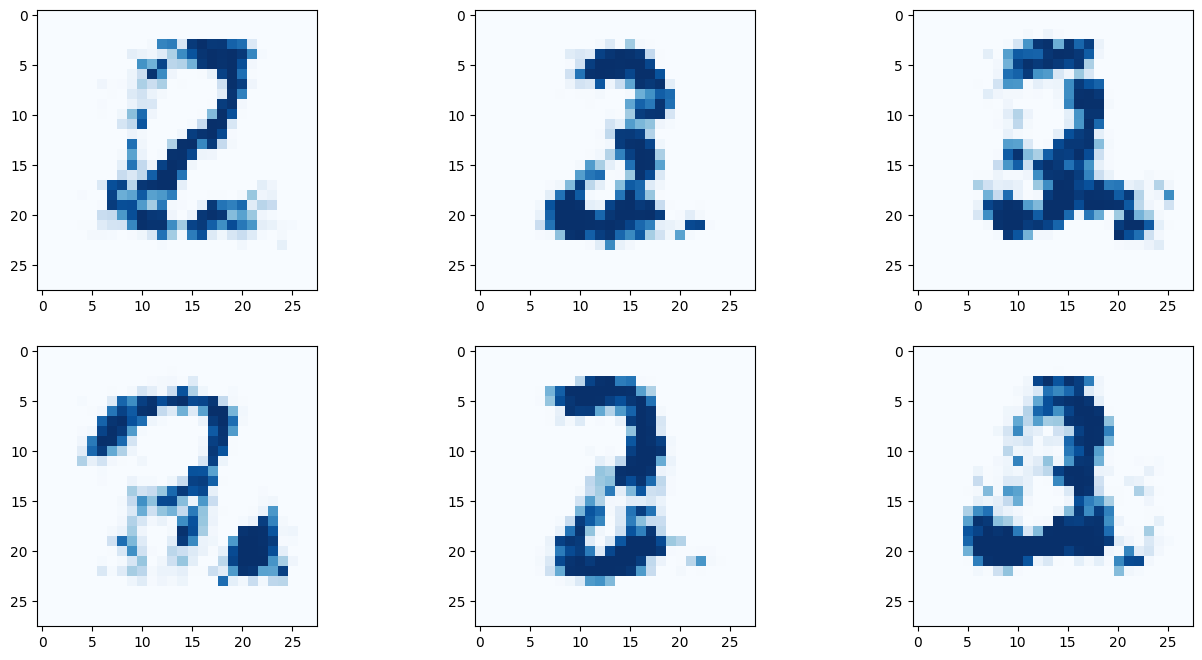

In [ ]:
G.plot_images(2)

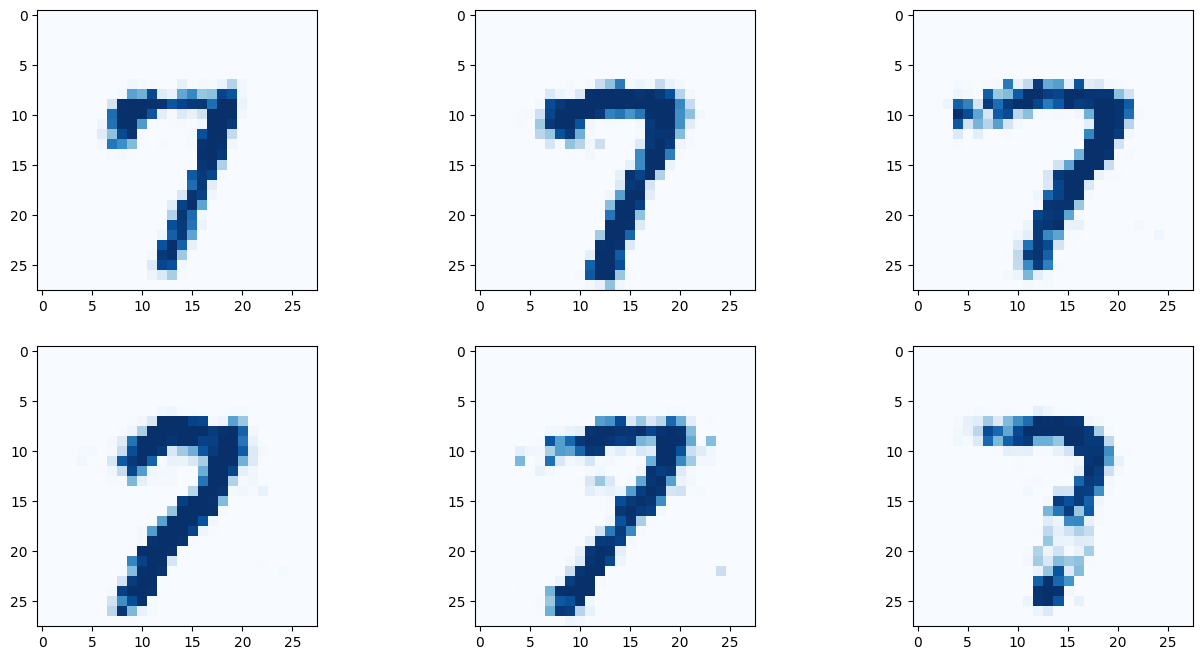

In [ ]:
G.plot_images(7)